<a href="https://colab.research.google.com/github/JoDeMiro/ImageProcessing/blob/main/18_Image_Mask_Detection_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Arc maszk detekálás PyTorch és ResNet101 segítségével

[Fejlesztés alatt, csak a vázat írtam meg, a magyarázatok még hiányoznak]

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import time
import os
import shutil
import time
import copy
import glob
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from PIL import Image

In [87]:
!git clone https://github.com/prajnasb/observations

fatal: destination path 'observations' already exists and is not an empty directory.


In [88]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


### Creating image datasets an data loaders for train and test using the experiments folder split

In [89]:
experiments_path = 'observations/experiements/dest_folder/'
data_path = 'observations/experiements/data/'

In [90]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [91]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [92]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)
    

In [93]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [94]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [95]:
%%capture
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

In [96]:
%%capture
for file_path, font_class in zip(X_test, y_test):
    copy_images_to_path(file_path, font_class, test_dir)

In [97]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [98]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [99]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [102]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fc6dace0fd0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fc6dace0590>}

In [103]:
class_names = image_datasets['train'].classes

In [104]:
class_names

['with_mask', 'without_mask']

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [106]:
device

device(type='cuda', index=0)

In [107]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

### Visualizing images

In [108]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [109]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

In [110]:
# imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [111]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [112]:
import ssl

In [113]:
ssl._create_default_https_context = ssl._create_unverified_context

In [114]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [115]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.2217 Acc:0.9110

test Loss: 0.0252 Acc:0.9845

Epoch 1/19
----------
train Loss: 0.1102 Acc:0.9483

test Loss: 0.0010 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.0868 Acc:0.9582

test Loss: 0.0031 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0779 Acc:0.9605

test Loss: 0.0015 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0834 Acc:0.9620

test Loss: 0.2311 Acc:0.9588

Epoch 5/19
----------
train Loss: 0.1128 Acc:0.9627

test Loss: 0.0688 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.1172 Acc:0.9582

test Loss: 0.0177 Acc:0.9948

Epoch 7/19
----------
train Loss: 0.0824 Acc:0.9665

test Loss: 0.0051 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0797 Acc:0.9627

test Loss: 0.0084 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0808 Acc:0.9643

test Loss: 0.0048 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0744 Acc:0.9635

test Loss: 0.0061 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0730 Acc:0.9635

test Loss: 0.0036 Acc:1.0000

Ep

In [116]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [117]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [118]:
!cd /content/gdrive/

In [119]:
!ls

gdrive	      woman_with_mask1.jpg    woman_with_mask3.jpg
observations  woman_with_mask1.jpg.1  woman_with_mask3.jpg.1
sample_data   woman_with_mask2.jpg    woman_with_mask4.jpg
woman2.jpg    woman_with_mask2.jpg.1  woman_with_mask4.jpg.1


In [120]:
torch.save(model_ft, '/content/gdrive/My Drive/mask1_model_resnet101.pth')

In [121]:
visualize_model(model_ft)

tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0') predicitons
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask


## Predikció - Van-e maszk vagy nincs az az arcon?

In [123]:
def process_image(image):
    ''' Átméretezés, levágás, és normalizáció a PIL image segítségével PyTorch modellhez,
        return Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # pil_image = Image.open(image)
    pil_image = image
   
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(pil_image)
    return img
    

In [124]:
%%capture
!wget https://github.com/JoDeMiro/OpenCVTutorial/raw/main/woman2.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask1.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask2.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask3.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask4.jpg

In [132]:
def classify_face(image):
    device = torch.device("cpu")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #im_pil = image.fromarray(image)
    #image = np.asarray(im)
    im = Image.fromarray(image)
    image = process_image(im)
    print('image_processed')
    img = image.unsqueeze_(0)
    img = image.float()

    model.eval()
    model.cpu()
    output = model(image)
    print(output,'--------------output--------------')
    _, predicted = torch.max(output, 1)
    print(predicted.data[0],"predicted")


    classification1 = predicted.data[0]
    index = int(classification1)
    print(class_names[index])
    return class_names[index]


In [128]:

filepath = '/content/gdrive/My Drive/mask1_model_resnet101.pth'


model = torch.load(filepath)

class_names = ['with_mask', 'without_mask']

image = cv2.imread('woman2.jpg')
image_woman_with_mask1 = cv2.imread('woman_with_mask1.jpg')
image_woman_with_mask2 = cv2.imread('woman_with_mask3.jpg')


image_processed
tensor([[-10.4810,   8.8592]], grad_fn=<AddmmBackward>) --------------output--------------
tensor(1) predicted
without_mask
image_processed
tensor([[ 3.1396, -3.8043]], grad_fn=<AddmmBackward>) --------------output--------------
tensor(0) predicted
with_mask
image_processed
tensor([[ 2.6777, -3.6785]], grad_fn=<AddmmBackward>) --------------output--------------
tensor(0) predicted
with_mask


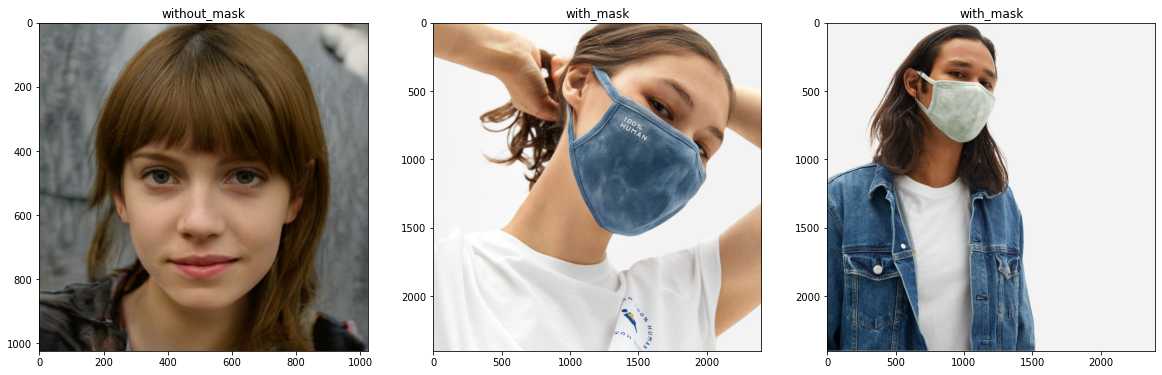

In [134]:
# cv2_imshow(image)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
label = classify_face(image)
ax1.set_title(label)
ax2.imshow(cv2.cvtColor(image_woman_with_mask1, cv2.COLOR_BGR2RGB))
label = classify_face(image_woman_with_mask1)
ax2.set_title(label)
ax3.imshow(cv2.cvtColor(image_woman_with_mask2, cv2.COLOR_BGR2RGB))
label = classify_face(image_woman_with_mask2)
ax3.set_title(label)
plt.show()